In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import nn
import math
import random
import scipy.stats as stats

In [0]:
class G1(nn.Module):
  def __init__(self):
    super(G1, self).__init__()
    self.GN = nn.Sequential(
        nn.Linear(1,4),
        nn.ReLU(),
        nn.Linear(4,8),
        nn.ReLU(),
        nn.Linear(8,4),
        nn.ReLU(),
        nn.Linear(4,1))
   
  def forward(self,x):
    x=self.GN(x)
    return x  

In [0]:
class D1(nn.Module):
  def __init__(self):
    super(D1, self).__init__()
    self.DN = nn.Sequential(
        nn.Linear(1,4),
        nn.ReLU(),
        nn.Linear(4,8),
        nn.ReLU(),
        nn.Linear(8,4),
        nn.ReLU(),
        nn.Linear(4,1),
        nn.Sigmoid())
   
  def forward(self,x):
    x=self.DN(x)
    return x

In [0]:
dlr=3e-2
glr=1e-2
K=10
epochs=100

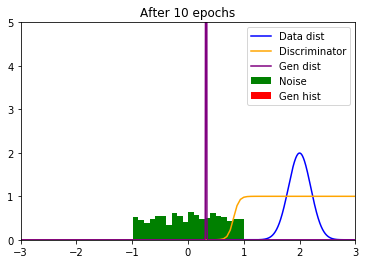

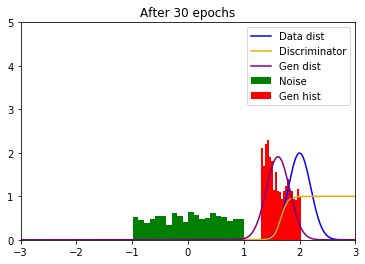

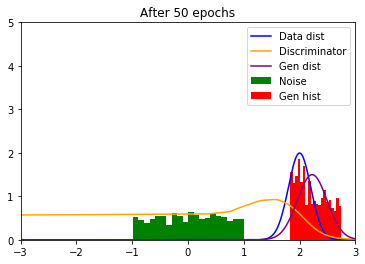

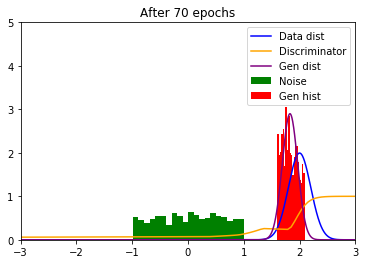

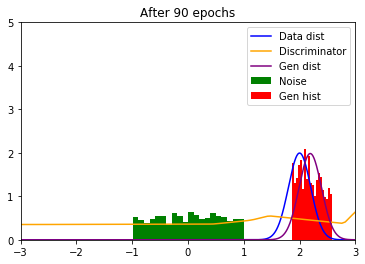

In [236]:
dmod=D1()
gmod=G1()
criterion = nn.BCELoss()
optimizer1 = torch.optim.Adam(dmod.parameters(),lr=dlr,eps=1e-9)
optimizer2 = torch.optim.Adam(gmod.parameters(),lr=glr,eps=1e-9)
trainingloss_list = []
bins1 = np.linspace(-1, 1, 20)
x=np.random.uniform(-1,1,1000)
x=x.reshape(1000,1)
for epoch in range(epochs):
  for k in range(K):
    optimizer1.zero_grad()

    dx=torch.from_numpy(np.random.normal(2,0.2,(64,1)))
    dout=dmod(dx.float())
    dloss1=criterion(dout,torch.ones(64,1))
    dloss1.backward()
    trainingloss_list.append(dloss1.item())
    gx=torch.from_numpy(np.random.uniform(-1,1,(64,1)))
    gy=gmod(gx.float())
    dgout=dmod(gy.float())
    dloss2=criterion(dgout,torch.zeros(64,1))
    dloss2.backward()
    optimizer1.step()

  optimizer2.zero_grad()
  gx=torch.from_numpy(np.random.uniform(-1,1,(64,1)))
  gy=gmod(gx.float())
  dgout=dmod(gy.float())
  gloss=criterion(dgout,torch.ones(64,1))
  gloss.backward()
  optimizer2.step()

  if(epoch%20==10):
    axes=plt.axes()
    axes.set_xlim([-3,3])
    axes.set_ylim([0,5])

    x1 = np.linspace(-3, 3, 1000)
    y1 = stats.norm.pdf(x1,2,0.2)
    plt.plot(x1,y1, color='Blue',label='Data dist')

    x2 = np.linspace(-3, 3, 100)
    x21=x2.reshape(100,1)
    y2=dmod(torch.from_numpy(x21).float())
    plt.plot(x2,y2.detach().numpy(), color='Orange',label='Discriminator')

    a=gmod(torch.from_numpy(x).float())
    plt.hist(x,20, facecolor='green', label='Noise',density=True)
    plt.hist(a.detach().numpy(),20, facecolor='red',label='Gen hist',density=True)

    mean=a.detach().numpy().mean()
    std=np.std(a.detach().numpy())
    x4 = np.linspace(-3, 3, 1000)
    y4 = stats.norm.pdf(x4,mean,std)
    plt.plot(x4,y4, color='Purple',label='Gen dist')

    plt.title('After %i epochs' %epoch)
    plt.legend()
    plt.show()

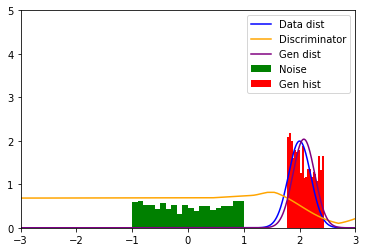

In [237]:
axes=plt.axes()
axes.set_xlim([-3,3])
axes.set_ylim([0,5])

x1 = np.linspace(-3, 3, 1000)
y1 = stats.norm.pdf(x1,2,0.2)
plt.plot(x1,y1, color='Blue',label='Data dist')

x2 = np.linspace(-3, 3, 100)
x21=x2.reshape(100,1)
y2=dmod(torch.from_numpy(x21).float())
plt.plot(x2,y2.detach().numpy(), color='Orange',label='Discriminator')

bins1 = np.linspace(-1, 1, 20)
x=np.random.uniform(-1,1,1000)
x=x.reshape(1000,1)
a=gmod(torch.from_numpy(x).float())
plt.hist(x,20, facecolor='green', label='Noise',density=True)
plt.hist(a.detach().numpy(),20, facecolor='red',label='Gen hist',density=True)

mean=a.detach().numpy().mean()
std=np.std(a.detach().numpy())
x4 = np.linspace(-3, 3, 1000)
y4 = stats.norm.pdf(x4,mean,std)
plt.plot(x4,y4, color='Purple',label='Gen dist')


plt.legend()
plt.show()

In [0]:
transform = transforms.ToTensor()
trainset = datasets.MNIST('', download=True, train=True, transform=transform)
testset = datasets.MNIST('',download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=500)
testloader = torch.utils.data.DataLoader(testset,batch_size=500)

In [0]:
class VAE(nn.Module):
  def __init__(self,hidsize):
    super(VAE, self).__init__()
    self.hidsize=hidsize

    self.encoder = nn.Sequential(
        nn.Linear(784,hidsize),
        nn.ReLU(),
        nn.Linear(hidsize,hidsize),
        nn.ReLU())
    
    self.mu = nn.Linear(hidsize,20)

    self.logvar = nn.Linear(hidsize,20)

    self.decoder = nn.Sequential(
        nn.Linear(20,hidsize),
        nn.ReLU(),
        nn.Linear(hidsize,hidsize),
        nn.ReLU(),
        nn.Linear(hidsize,784),
        nn.Sigmoid())

  def forward(self,x):
    x=self.encoder(x)
    mu=self.mu(x)
    logvar=self.logvar(x)
    std = torch.exp(0.5*logvar)
    e=torch.randn_like(std)
    z=e.mul(std).add(mu)
    xpre=self.decoder(z)
    return mu,logvar,xpre

In [0]:
vae1=VAE(100)
LearningRate=3e-3
epochs=10
criterion = nn.BCELoss(reduction='sum')
optimizer = torch.optim.Adam(vae1.parameters(),lr=LearningRate)

In [247]:
trainingloss_list1 = []
for epoch in range(epochs):
  for images, labels in trainloader:
    images=images.reshape(500,784)
    mu,log_var,pre = vae1(images.float())
    loss = criterion(pre, images)-0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    trainingloss_list1.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print('Epoch',epoch+1,'out of',epochs,'epochs are over')

Epoch 1 out of 10 epochs are over
Epoch 2 out of 10 epochs are over
Epoch 3 out of 10 epochs are over
Epoch 4 out of 10 epochs are over
Epoch 5 out of 10 epochs are over
Epoch 6 out of 10 epochs are over
Epoch 7 out of 10 epochs are over
Epoch 8 out of 10 epochs are over
Epoch 9 out of 10 epochs are over
Epoch 10 out of 10 epochs are over


In [0]:
vae2=VAE(200)
LearningRate=3e-3
epochs=10
criterion = nn.BCELoss(reduction='sum')
optimizer = torch.optim.Adam(vae2.parameters(),lr=LearningRate)

In [249]:
trainingloss_list2 = []
for epoch in range(epochs):
  for images, labels in trainloader:
    images=images.reshape(500,784)
    mu,log_var,pre = vae2(images.float())
    loss = criterion(pre, images)-0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    trainingloss_list2.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print('Epoch',epoch+1,'out of',epochs,'epochs are over')

Epoch 1 out of 10 epochs are over
Epoch 2 out of 10 epochs are over
Epoch 3 out of 10 epochs are over
Epoch 4 out of 10 epochs are over
Epoch 5 out of 10 epochs are over
Epoch 6 out of 10 epochs are over
Epoch 7 out of 10 epochs are over
Epoch 8 out of 10 epochs are over
Epoch 9 out of 10 epochs are over
Epoch 10 out of 10 epochs are over


In [0]:
vae3=VAE(300)
LearningRate=3e-3
epochs=10
criterion = nn.BCELoss(reduction='sum')
optimizer = torch.optim.Adam(vae3.parameters(),lr=LearningRate)

In [251]:
trainingloss_list3 = []
for epoch in range(epochs):
  for images, labels in trainloader:
    images=images.reshape(500,784)
    mu,log_var,pre = vae3(images.float())
    loss = criterion(pre, images)-0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    trainingloss_list3.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print('Epoch',epoch+1,'out of',epochs,'epochs are over')

Epoch 1 out of 10 epochs are over
Epoch 2 out of 10 epochs are over
Epoch 3 out of 10 epochs are over
Epoch 4 out of 10 epochs are over
Epoch 5 out of 10 epochs are over
Epoch 6 out of 10 epochs are over
Epoch 7 out of 10 epochs are over
Epoch 8 out of 10 epochs are over
Epoch 9 out of 10 epochs are over
Epoch 10 out of 10 epochs are over


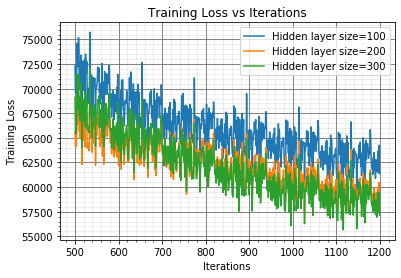

In [260]:
plt.figure(1)
xtrainloss=np.arange(len(trainingloss_list1))
plt.plot(xtrainloss[500:],trainingloss_list1[500:],label='Hidden layer size=100')
plt.plot(xtrainloss[500:],trainingloss_list2[500:],label='Hidden layer size=200')
plt.plot(xtrainloss[500:],trainingloss_list3[500:],label='Hidden layer size=300')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Iterations')
plt.legend()
plt.show()

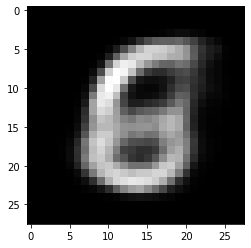

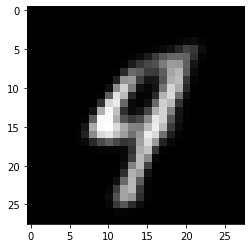

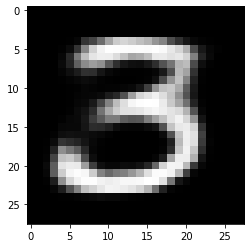

In [259]:
z = torch.from_numpy(np.random.normal(0,1,(1,20)))
output1 = vae1.decoder(z.float())
output2 = vae2.decoder(z.float())
output3 = vae3.decoder(z.float())
plt.imshow(output1.detach().numpy().reshape(28,28),cmap='gray')
plt.show()
plt.imshow(output2.detach().numpy().reshape(28,28),cmap='gray')
plt.show()
plt.imshow(output3.detach().numpy().reshape(28,28),cmap='gray')
plt.show()

In [0]:
imageset=np.zeros((10,28,28))
imageset=torch.from_numpy(imageset)
imageset=imageset.float()
complabel=0
while(complabel<10):
  for images,labels in testloader:
    for i in range(labels.size(0)):
      if(labels[i]==complabel):
        imageset[complabel]=images[i].clone()
        complabel+=1

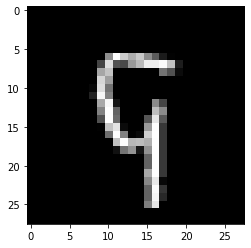

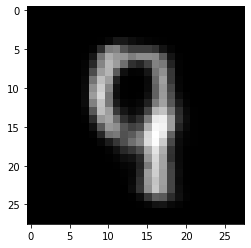

In [0]:
mu,std,pre=vae(imageset[9].reshape(1,784))
plt.imshow(imageset[9].reshape(28,28),cmap='gray')
plt.show()
plt.imshow(pre.detach().numpy().reshape(28,28),cmap='gray')
plt.show()

In [0]:
class ConvVAE(nn.Module):
  def __init__(self):
    super(ConvVAE, self).__init__()
    
    self.conv1=nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=0)
    self.conv2=nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=0)
    self.deconv1=nn.ConvTranspose2d(16, 8, kernel_size=3, stride=1, padding=0)
    self.deconv2=nn.ConvTranspose2d(8,1,kernel_size=3, stride=1, padding=0)
    self.relu=nn.ReLU()
    self.sig=nn.Sigmoid()
    self.linencoder=nn.Sequential(
        nn.Linear(24*24*16,300),
        nn.ReLU(),
        nn.Linear(300,300),
        nn.ReLU())  
    
    self.mu = nn.Linear(300,20)

    self.logvar = nn.Linear(300,20)

    self.lindecoder = nn.Sequential(
        nn.Linear(20,300),
        nn.ReLU(),
        nn.Linear(300,300),
        nn.ReLU(),
        nn.Linear(300,24*24*16),
        nn.ReLU())

  def encoder(self,x):
    x=self.relu(self.conv1(x))
    x=self.relu(self.conv2(x))
    x=x.reshape(x.size(0), -1)    
    x=self.linencoder(x)
    return x

  def decoder(self,z):
    z=self.lindecoder(z)
    z=z.reshape(-1,16,24,24)
    z=self.deconv1(z)
    z=self.relu(z)
    z=self.deconv2(z)
    xpre=self.sig(z)
    return xpre

  def forward(self,x):
    x=self.encoder(x)
    
    mu=self.mu(x)
    logvar=self.logvar(x)
    std = torch.exp(0.5*logvar)
    e=torch.randn_like(std)
    z=e.mul(std).add(mu)

    xpre=self.decoder(z)

    return mu,logvar,xpre

In [61]:
vae=ConvVAE()
LearningRate=3e-3
epochs=10
criterion = nn.BCELoss(reduction='sum')
optimizer = torch.optim.Adam(vae.parameters(),lr=LearningRate)

trainingloss_list = []
for epoch in range(epochs):
  for images, labels in trainloader:
    mu,log_var,pre = vae(images.float())
    loss = criterion(pre, images)-0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    trainingloss_list.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print('Epoch',epoch+1,'out of',epochs,'epochs are over')

Epoch 1 out of 10 epochs are over
Epoch 2 out of 10 epochs are over
Epoch 3 out of 10 epochs are over
Epoch 4 out of 10 epochs are over
Epoch 5 out of 10 epochs are over
Epoch 6 out of 10 epochs are over
Epoch 7 out of 10 epochs are over
Epoch 8 out of 10 epochs are over
Epoch 9 out of 10 epochs are over
Epoch 10 out of 10 epochs are over


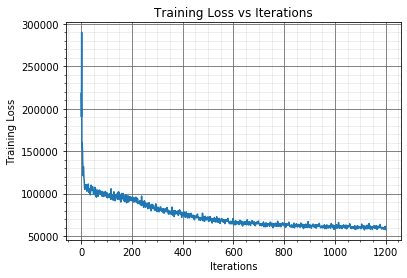

In [80]:
plt.figure(1)
xtrainloss=np.arange(len(trainingloss_list))
plt.plot(xtrainloss[:],trainingloss_list[:])
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Iterations')
plt.show()

In [0]:
imageset=np.zeros((10,1,28,28))
imageset=torch.from_numpy(imageset)
imageset=imageset.float()
complabel=0
while(complabel<10):
  for images,labels in testloader:
    for i in range(labels.size(0)):
      if(labels[i]==complabel):
        imageset[complabel]=images[i].clone()
        complabel+=1

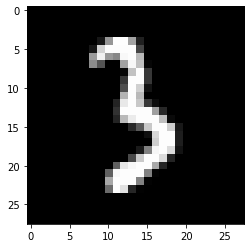

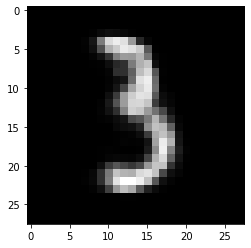

In [63]:
mu,std,pre=vae(imageset)
plt.imshow(imageset[3].reshape(28,28),cmap='gray')
plt.show()
plt.imshow(pre.detach().numpy()[3].reshape(28,28),cmap='gray')
plt.show()

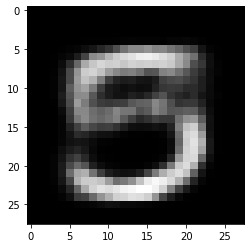

In [266]:
z = torch.from_numpy(np.random.normal(0,1,(1,20)))
output = vae.decoder(z.float())
plt.imshow(output.detach().numpy().reshape(28,28),cmap='gray')
plt.show()